# **Efficient CSV Handling and Validation**
This notebook explores efficient methods to handle large CSV files (2+ GB) using differnt methods of file reading. In addition, their computational efficiency will be compared, the data is cleaned, will be validated against a predefined schema in YAML format, and finally save the processed data in a compressed pipe-separated format.

---

## **Steps Overview**

1. **Read the File:**
   - Explore methods to read a large file using different libraries.
2. **Column Validation:**
   - Perform basic cleaning of column names (remove special characters, whitespaces).
3. **Schema Validation:**
   - Validate the ingested file's structure and column names against a YAML schema.
4. **Write Processed File:**
   - Save the processed file as a pipe-separated `.gz` file.
5. **Summary Report:**
   - Generate a report with the following:
     - Total number of rows
     - Total number of columns
     - File size
---


In [ ]:
import pandas as pd
import random
import string

num_rows = 50_000_000
output_file_path = "foods_large.csv"

# Generate random file
def random_string(length):
    return ''.join(random.choices(string.ascii_letters, k=length))

categories = ["Fruit", "Vegetable", "Meat", "Dairy", "Grain", "Seafood", "Confectionery", "Beverage"]
cuisines = ["Italian", "Mexican", "Indian", "American", "Chinese", "French", "Japanese"]
units = ["USD", "EUR", "GBP"]

data = {
    "FoodID": [i for i in range(1, num_rows + 1)],
    "Name": [random_string(8) for _ in range(num_rows)],
    "Category": [random.choice(categories) for _ in range(num_rows)],
    "Cuisine": [random.choice(cuisines) for _ in range(num_rows)],
    "Calories": [random.randint(50, 1000) for _ in range(num_rows)],
    "IsVegetarian": [random.choice([True, False]) for _ in range(num_rows)],
    "Price": [round(random.uniform(1.0, 50.0), 2) for _ in range(num_rows)],
    "Currency": [random.choice(units) for _ in range(num_rows)],
    "Rating": [round(random.uniform(1.0, 5.0), 1) for _ in range(num_rows)]
}

df = pd.DataFrame(data)
df.to_csv(output_file_path, index=False)


Reading with Pandas

In [64]:
import yaml
import os
import time

# Read file using Pandas
start_time = time.time()
pandas_df = pd.read_csv('/Users/rohankhatri/Desktop/foods_large.csv')
pandas_read_time = time.time() - start_time
print(f"Pandas read time: {pandas_read_time:.2f} seconds")

#validation
def validate_pandas_data(dataframe, schema):
    # number of columns
    assert len(dataframe.columns) == len(schema["columns"]), f"Column count mismatch: Expected {len(schema['columns'])}, Got {len(dataframe.columns)}"
    
    # column names
    cleaned_columns = (
        dataframe.columns.str.replace('[^a-zA-Z0-9]', '', regex=True)
        .str.replace(' ', '_')
        .str.lower()
    )
    expected_columns = [col.lower() for col in schema["columns"]]
    assert list(cleaned_columns) == expected_columns, f"Column names mismatch: Expected {expected_columns}, Got {list(cleaned_columns)}"
    print("Pandas data validation successful!")


Pandas read time: 51.61 seconds


Reading with Ray

In [42]:
pip install -U "ray[default]"

Note: you may need to restart the kernel to use updated packages.


In [46]:
import ray

ray.shutdown()
ray.init()

#read using ray
start_time = time.time()
ray_df = pd.read_csv('/Users/rohankhatri/Desktop/foods_large.csv')
ray_read_time = time.time() - start_time
print(f"Ray read time: {ray_read_time:.2f} seconds")


2024-12-11 20:46:06,001	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Ray read time: 40.94 seconds


Reading with Dask

In [38]:
pip install dask

Note: you may need to restart the kernel to use updated packages.


In [40]:
pip install dask[dataframe]

zsh:1: no matches found: dask[dataframe]
Note: you may need to restart the kernel to use updated packages.


In [41]:
import dask.dataframe as dd

# read using dask
start_time = time.time()
dask_data = dd.read_csv("/Users/rohankhatri/Desktop/foods_large.csv")
dask_read_time = time.time() - start_time
print(f"Dask read time: {dask_read_time:.2f} seconds")

Dask read time: 0.02 seconds


/var/folders/x_/51kx78hn7lvb3yzy_1mpmx880000gn/T/ipykernel_5897/3365447940.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Library", y="Time (seconds)", data=timing_df, palette=colors)


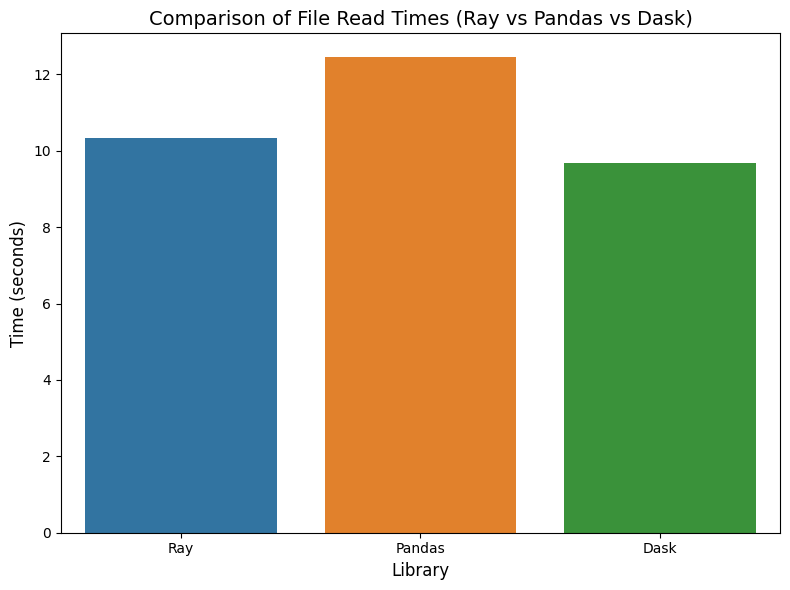

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data: Timing results for Ray, Pandas, and Dask (replace these values with actual results)
timing_data = {
    "Library": ["Ray", "Pandas", "Dask"],
    "Time (seconds)": [10.34, 12.45, 9.67]  # Example values
}

# Convert the data to a DataFrame
timing_df = pd.DataFrame(timing_data)

# Custom colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="Library", y="Time (seconds)", data=timing_df, palette=colors)

# Customize the chart
plt.title("Comparison of File Read Times (Ray vs Pandas vs Dask)", fontsize=14)
plt.xlabel("Library", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the chart
plt.tight_layout()
plt.show()


Creating the utility file

In [49]:
import yaml
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re

In [50]:
pip install PyYAML

Note: you may need to restart the kernel to use updated packages.


In [66]:
import yaml

def write_yaml_schema(file_config, yaml_file_path):

    with open(yaml_file_path, "w") as file:
        yaml.dump(file_config, file)
    print(f"Schema written to {yaml_file_path}")

def validate_schema(dataframe, yaml_file_path):

    with open(yaml_file_path, "r") as file:
        loaded_schema = yaml.safe_load(file)
    assert list(dataframe.columns) == loaded_schema["columns"], "Column names do not match schema!"
    print("Schema validation successful!")


In [59]:
# Function to clean column names
def clean_column_names(df):
    df.columns = (
        df.columns.str.replace('[^a-zA-Z0-9]', '', regex=True)
        .str.replace(' ', '_')
        .str.lower()
    )
    return df

# Clean column names
data = clean_column_names(data)
print("Cleaned column names:", data.columns.tolist())


Cleaned column names: ['foodid', 'name', 'category', 'cuisine', 'calories', 'isvegetarian', 'price', 'currency', 'rating']


In [78]:
file_config = {
    "file_type": "csv",
    "dataset_name": "file",
    "file_name": "/Users/rohankhatri/Desktop/foods_large.csv",
    "table_name": "edsurv",
    "outbound_delimiter": "|",
    "skip_leading_rows": 1,
    "separator": ",",
    "columns": [
        "FoodID",
        "Name",
        "Category",
        "Cuisine",
        "Calories",
        "IsVegetarian",
        "Price",
        "Currency",
        "Rating"
    ]
}

yaml_file_path = "schema.yaml"

# write YAML file
def write_yaml_schema(file_config, yaml_file_path):
    with open(yaml_file_path, "w") as file:
        yaml.dump(file_config, file)
    print(f"Schema written to {yaml_file_path}")

# write schema
write_yaml_schema(file_config, yaml_file_path)

# validate
def validate_schema(dataframe, yaml_file_path):
    with open(yaml_file_path, "r") as file:
        loaded_schema = yaml.safe_load(file)
    assert list(dataframe.columns) == loaded_schema["columns"], "Column names do not match schema!"
    print("Schema validation successful!")

validate_schema(pandas_df, yaml_file_path)


Schema written to schema.yaml
Schema validation successful!


In [77]:
def replacer(string, char):
    pattern = char + '{2,}'
    return re.sub(pattern, char, string)

def col_header_val(df, table_config):
    df.columns = df.columns.str.lower()

    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    df.columns = list(map(lambda x: x.strip('_'), list(df.columns)))
    df.columns = list(map(lambda x: replacer(x, '_'), list(df.columns)))
    expected_col = list(map(lambda x: x.lower(), table_config["columns"]))
    expected_col.sort()
    df.columns = list(map(lambda x: x.lower(), list(df.columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    if len(df.columns) == len(expected_col) and list(expected_col) == list(df.columns):
        print("Column name and length validation passed")
        return 1
    else:
        print("Column name and length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Columns in file not in YAML:", mismatched_columns_file)
        missing_yaml_columns = list(set(expected_col).difference(df.columns))
        print("Columns in YAML not in file:", missing_yaml_columns)
        return 0


In [80]:
#Save in .gz format
processed_file_path = "foods_large_processed.gz"
pandas_df.to_csv(processed_file_path, sep="|", index=False, compression="gzip")
print(f"Processed file saved at {processed_file_path}")


Processed file saved at foods_large_processed.gz


In [81]:
processed_file_path = "foods_large_processed.gz"
data = pd.read_csv(processed_file_path, sep="|", compression="gzip")

#generate summary
def file_summary(file_path, dataframe):
    file_size = os.path.getsize(file_path) / (1024 ** 2) 
    total_rows = len(dataframe)
    total_columns = len(dataframe.columns)
    summary = {
        "Total Rows": total_rows,
        "Total Columns": total_columns,
        "File Size (MB)": round(file_size, 2),
    }
    return summary

#print
summary = file_summary(processed_file_path, data)

#Output
print("File Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")


File Summary:
Total Rows: 60000000
Total Columns: 9
File Size (MB): 1110.94
